<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/UNSW_NB15_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


## **Get Data from Kaggle**

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kiranmahesh/nslkdd

! unzip nslkdd.zip

In [12]:
#! wget  https://github.com/nht0017/HIDS/blob/main/Datasets/UNSW-NB15/UNSW_NB15_testing-set.csv
#! wget  https://github.com/nht0017/HIDS/blob/main/Datasets/UNSW-NB15/UNSW_NB15_training-set.csv

--2021-08-12 18:43:01--  https://github.com/nht0017/HIDS/blob/main/Datasets/UNSW-NB15/UNSW_NB15_testing-set.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘UNSW_NB15_testing-set.csv’

UNSW_NB15_testing-s     [ <=>                ] 124.32K   643KB/s    in 0.2s    

2021-08-12 18:43:02 (643 KB/s) - ‘UNSW_NB15_testing-set.csv’ saved [127307]



# **Data Process**

In [121]:
# Get a list of files from this dir
files_list = os.listdir()

#files_list.sort()

files_list

['.config',
 '200901.tar.gz',
 '200901.tar',
 'UNSW_NB15_training-set.csv',
 '.ipynb_checkpoints',
 'UNSW_NB15_testing-set.csv',
 'sample_data']

## **Read in Data**

Since Test and Train data comtain some different labels, we combine them together and then split into training and testing sets later

train_df = pd.read_csv('UNSW_NB15_training-set.csv', sep=',', header=0)
test_df = pd.read_csv('UNSW_NB15_testing-set.csv', sep=',', header=0)

In [122]:
#INDEX =  0#@param {type:"integer"}

# Get df name
DATA = 'UNSW-NB15'
print('DATA:', DATA)
csv_file = ['UNSW_NB15_testing-set.csv', 'UNSW_NB15_training-set.csv']

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=',', header=0))

df = pd.concat(list_of_dataframes, ignore_index=True)
df

#test_df = pd.read_csv('kdd_test.csv', sep=',', header=0, engine='python')

DATA: UNSW-NB15


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350677,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
350678,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
350679,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
350680,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [123]:
df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,350682.000000,350682.000000,350682.000000,350682.000000,3.506820e+05,3.506820e+05,3.506820e+05,350682.000000,350682.000000,3.506820e+05,3.506820e+05,350682.000000,350682.000000,350682.000000,350682.000000,3.506820e+05,350682.000000,350682.000000,3.506820e+05,3.506820e+05,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,3.506820e+05,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.658943,6.480240,136.887402,110.258113,1.747654e+05,1.436540e+05,1.654007e+05,102.939864,110.506706,1.883572e+08,2.421309e+06,66.004964,52.732924,7242.235515,987.091787,4.496578e+04,4061.037491,127.000843,1.355262e+09,1.353998e+09,126.886349,0.079354,0.043400,0.040506,204.677068,258.316688,0.776910,5.420789e+04,10.704316,0.954405,8.052465,8.047093,5.783577,10.956170,0.126048,0.126048,0.701207,8.321481,10.756937,0.124515,0.466236
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [124]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0
if filt.any == True:
  print(df.loc[:,filt])

# Drop id col
df.drop(columns='id', inplace=True)

## **Encoding Label**

In [125]:
# If a class has < 2 instances --> drop it
filt = df['attack_cat'].value_counts() < 4
drop_class = filt[filt == True] # Assuming only 1 class has 1 instance
drop_class = drop_class.to_frame()
drop_class.reset_index(inplace=True)
print('A class with only 1 instance is ',drop_class['index'])


A class with only 1 instance is  Series([], Name: index, dtype: object)


In [126]:
print('df shape before dropping:', df.shape) 

for i in drop_class['index']:
  class_filt = df['labels'] == i
  df.drop(index = df[class_filt].index, inplace = True) 

print('df shape after dropping:', df.shape)

df shape before dropping: (350682, 44)
df shape after dropping: (350682, 44)


In [127]:
OG_labels = sorted(df['attack_cat'].unique())
n_classes = len(OG_labels)

# Encoding label for test data
print('Before encoding Label: ', OG_labels)
lb_maker = LabelEncoder().fit(OG_labels)
df['encoded_labels'] = lb_maker.transform(df['attack_cat'])

df.drop(columns=['label'], inplace=True)
print(df.shape)

encoded_labels = sorted( list(df['encoded_labels'].unique()))

labels_dict = dict(zip(range(len(lb_maker.classes_)), lb_maker.classes_, ))
labels_dict

Before encoding Label:  ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']
(350682, 44)


{0: 'Analysis',
 1: 'Backdoor',
 2: 'DoS',
 3: 'Exploits',
 4: 'Fuzzers',
 5: 'Generic',
 6: 'Normal',
 7: 'Reconnaissance',
 8: 'Shellcode',
 9: 'Worms'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [128]:
# Removing NaN
df.dropna(axis=1, how='any', inplace=True)
print(df.shape)
df.drop(columns='attack_cat', inplace=True)

(350682, 44)


In [129]:
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,encoded_labels
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,6
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350677,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,5
350678,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,8
350679,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,5
350680,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,5


In [130]:
# Encoding protocol_type
print(df['proto'].unique())

encoder = LabelEncoder().fit(df['proto'])
df['encoded_proto'] = encoder.transform(df['proto'])

df.drop(columns=['proto'], inplace=True)
print(df.shape)
df.head()

['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 'xns-idp' 'leaf-1' 'leaf-2'
 'rdp' 'irtp

,dur,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,encoded_labels,encoded_proto
0,0.121478,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,113
1,0.649902,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,113
2,1.623129,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,113
3,1.681642,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,6,113
4,0.449454,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,6,113


In [131]:
# Encoding service for train data
services = df['service'].unique().tolist()
services.sort()
print(len(services), services)

# Encoding label: 1 is normal, 0 is intrusion
encoder = LabelEncoder().fit(df['service'])
df['encoded_service'] = encoder.transform(df['service'])
#print(protocol_encoder.classes_)

df.drop(columns=['service'], inplace=True)
print(df.shape)
df.head()

13 ['-', 'dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'pop3', 'radius', 'smtp', 'snmp', 'ssh', 'ssl']
(350682, 43)


,dur,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,encoded_labels,encoded_proto,encoded_service
0,0.121478,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,113,0
1,0.649902,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,113,0
2,1.623129,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,113,0
3,1.681642,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,6,113,3
4,0.449454,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,6,113,0


In [132]:
# Encoding flag for train data
flags = df['state'].unique().tolist()
flags.sort()
print(len(flags), flags)
encoder = LabelEncoder().fit(df['state'])
df['encoded_state'] = encoder.transform(df['state'])

df.drop(columns=['state'], inplace=True)
print(df.shape)

df.head()

9 ['CON', 'ECO', 'FIN', 'INT', 'PAR', 'REQ', 'RST', 'URN', 'no']
(350682, 43)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,encoded_labels,encoded_proto,encoded_service,encoded_state
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,6,113,0,2
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,6,113,0,2
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,6,113,0,2
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,6,113,3,2
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,6,113,0,2


In [133]:
# Move col Labels to the last col
df['Labels'] = df['encoded_labels']
df.drop(columns=['encoded_labels'], inplace= True)
df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,encoded_proto,encoded_service,encoded_state,Labels
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,113,0,2,6
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,113,0,2,6
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,113,0,2,6
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,113,3,2,6
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,113,0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350677,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,119,2,3,5
350678,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,113,0,2,8
350679,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,119,2,3,5
350680,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,119,2,3,5


## **Feature Selection**

In [134]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df['Labels']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
print(best_features)  #print 30 best features


               Specs          Score
31  ct_dst_sport_ltm  159342.500941
32    ct_dst_src_ltm   88201.432751
37        ct_srv_dst   87362.902514
30  ct_src_dport_ltm   86781.189190
27        ct_srv_src   83052.028482
29        ct_dst_ltm   67414.440867
6               sttl   48280.894885
36        ct_src_ltm   43079.034218
28      ct_state_ttl   24118.771978
41     encoded_state   17831.690364
16              swin   17684.477913
19              dwin   16969.829795
7               dttl   14433.179901
5               rate   10806.779699
17             stcpb    9082.695505
18             dtcpb    9070.881510
24             dmean    7689.212748
20            tcprtt    7498.732185
9              dload    7152.071123
22            ackdat    7084.163416
21            synack    6224.191491
40   encoded_service    4546.256362
39     encoded_proto    3789.774174
23             smean    3279.226109
35  ct_flw_http_mthd    2939.575564
8              sload    1880.456561
38   is_sm_ips_ports    1375

In [135]:
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
 # print(row[ "Score"])
  if row[ "Score"] > 1000 :
    best_column_indices.append(index)

# Keep only columns w the best features
X = X.iloc[:, best_column_indices]
NUM_COLS = len(X.columns)
X 

,ct_dst_sport_ltm,ct_dst_src_ltm,ct_srv_dst,ct_src_dport_ltm,ct_srv_src,ct_dst_ltm,sttl,ct_src_ltm,ct_state_ttl,encoded_state,swin,dwin,dttl,rate,stcpb,dtcpb,dmean,tcprtt,dload,ackdat,synack,encoded_service,encoded_proto,smean,ct_flw_http_mthd,sload,is_sm_ips_ports,sinpkt
0,1,1,1,1,1,1,252,1,0,2,255,255,254,74.087490,621772692,2202533631,43,0.000000,8495.365234,0.000000,0.000000,0,113,43,0,1.415894e+04,0,24.295600
1,1,2,6,1,43,1,62,1,1,2,255,255,252,78.473372,1417884146,3077387971,1106,0.000000,503571.312500,0.000000,0.000000,0,113,52,0,8.395112e+03,0,49.915000
2,1,3,6,1,7,2,62,2,1,2,255,255,252,14.170161,2116150707,2963114973,824,0.111897,60929.230470,0.050439,0.061458,0,113,46,0,1.572272e+03,0,231.875571
3,1,3,1,1,1,2,62,2,1,2,255,255,252,13.677108,1107119177,1047442890,64,0.000000,3358.622070,0.000000,0.000000,3,113,52,0,2.740179e+03,0,152.876547
4,1,40,39,2,43,2,254,2,1,2,255,255,252,33.373826,2436137549,1977154190,45,0.128381,3987.059814,0.057234,0.071147,0,113,53,0,8.561499e+03,0,47.750333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350677,13,24,24,24,24,24,254,24,2,3,0,0,0,111111.107200,0,0,0,0.000000,0.000000,0.000000,0.000000,2,119,57,0,5.066666e+07,0,0.009000
350678,1,2,1,1,1,1,254,1,1,2,255,255,252,33.612649,3518776216,3453092386,44,0.099440,4903.492188,0.062545,0.036895,0,113,62,0,8.826286e+03,0,54.400111
350679,3,13,12,3,12,3,254,3,2,3,0,0,0,111111.107200,0,0,0,0.000000,0.000000,0.000000,0.000000,2,119,57,0,5.066666e+07,0,0.009000
350680,14,30,30,30,30,30,254,30,2,3,0,0,0,111111.107200,0,0,0,0.000000,0.000000,0.000000,0.000000,2,119,57,0,5.066666e+07,0,0.009000


In [136]:
X.describe()

,ct_dst_sport_ltm,ct_dst_src_ltm,ct_srv_dst,ct_src_dport_ltm,ct_srv_src,ct_dst_ltm,sttl,ct_src_ltm,ct_state_ttl,encoded_state,swin,dwin,dttl,rate,stcpb,dtcpb,dmean,tcprtt,dload,ackdat,synack,encoded_service,encoded_proto,smean,ct_flw_http_mthd,sload,is_sm_ips_ports,sinpkt
count,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,3.506820e+05,3.506820e+05,3.506820e+05,350682.000000,350682.000000,3.506820e+05,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,350682.000000,3.506820e+05,350682.000000,350682.000000
mean,4.206255,8.729881,9.100758,5.383538,9.306437,6.193936,179.546997,6.955789,1.304179,2.355176,116.257339,115.013625,79.609567,9.540619e+04,9.692504e+08,9.688770e+08,124.173382,0.041396,6.712056e+05,0.020375,0.021020,1.618920,109.606675,136.751769,0.133066,7.345403e+07,0.015752,985.976864
std,5.783577,10.956170,10.756937,8.047093,10.704316,8.052465,102.939864,8.321481,0.954405,0.867941,127.000843,126.886349,110.506706,1.654007e+05,1.355262e+09,1.353998e+09,258.316688,0.079354,2.421309e+06,0.040506,0.043400,2.305147,22.352569,204.677068,0.701207,1.883572e+08,0.124515,7242.235515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,62.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.278614e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,113.000000,57.000000,0.000000,1.305334e+04,0.000000,0.008000
50%,1.000000,3.000000,4.000000,1.000000,5.000000,2.000000,254.000000,3.000000,1.000000,2.000000,0.000000,0.000000,29.000000,3.225807e+03,0.000000e+00,0.000000e+00,44.000000,0.000000,1.447023e+03,0.000000,0.000000,0.000000,113.000000,73.000000,0.000000,8.796748e+05,0.000000,0.279733
75%,3.000000,12.000000,12.000000,5.000000,12.000000,7.000000,254.000000,9.000000,2.000000,3.000000,255.000000,255.000000,252.000000,1.250000e+05,1.916651e+09,1.913675e+09,89.000000,0.065481,2.784487e+04,0.038906,0.023268,2.000000,119.000000,100.000000,0.000000,8.888889e+07,0.000000,55.156896
max,46.000000,65.000000,62.000000,51.000000,63.000000,51.000000,255.000000,60.000000,6.000000,8.000000,255.000000,255.000000,254.000000,1.000000e+06,4.294959e+09,4.294882e+09,1458.000000,2.518893,2.242273e+07,1.520884,2.100352,12.000000,132.000000,1504.000000,30.000000,5.988000e+09,1.000000,84371.496000


In [137]:
y

0         6
1         6
2         6
3         6
4         6
         ..
350677    5
350678    8
350679    5
350680    5
350681    5
Name: Labels, Length: 350682, dtype: int64

## **Data Cleaning**

In [138]:
label_arr = np.arange(0, np.max(y.unique())+1)

label_arr

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Class 6 - Normal: n=112000 (31.938%)
---------> Major class 6
Class 1 - Backdoor: n=3492 (0.996%)
Class 0 - Analysis: n=4000 (1.141%)
Class 4 - Fuzzers: n=36368 (10.371%)
Class 8 - Shellcode: n=2266 (0.646%)
Class 7 - Reconnaissance: n=20982 (5.983%)
Class 3 - Exploits: n=66786 (19.045%)
Class 2 - DoS: n=24528 (6.994%)
Class 9 - Worms: n=260 (0.074%)
Class 5 - Generic: n=80000 (22.813%)


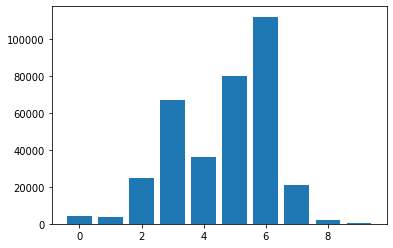

In [139]:
from collections import Counter

MAX_CASES = 1

# summarize distribution
counter = Counter(df['Labels'])
for k,v in counter.items():
  per = v / len(df['Labels']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [140]:
labels_dict

{0: 'Analysis',
 1: 'Backdoor',
 2: 'DoS',
 3: 'Exploits',
 4: 'Fuzzers',
 5: 'Generic',
 6: 'Normal',
 7: 'Reconnaissance',
 8: 'Shellcode',
 9: 'Worms'}

In [141]:
# get the encoded label of NORMAL class:
NORMAL_CLASS_INDEX = 0
for key, value in labels_dict.items():
  if value == 'Normal' or  value == 'normal':
    NORMAL_CLASS_INDEX = key
    break

print('The encoded label of NORMAL class is', NORMAL_CLASS_INDEX)

# check if normal class is the major class. If not, add normal class to another dataframe and add another sample of Normal dataframe into X; this way normal cases are oversampled.


The encoded label of NORMAL class is 6


## **Removing duplicates from multiple classes**

- Separate each class into a set
- Remove duplicate rows that exist in multiple classes by taking the difference between classes


In [142]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )


Before cleaning:
Class 0 len: 1594
Class 1 len: 1535
Class 2 len: 3806
Class 3 len: 19844
Class 4 len: 16148
Class 5 len: 4181
Class 6 len: 51682
Class 7 len: 7522
Class 8 len: 1091
Class 9 len: 127


In [143]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
class_sz = {}
for key, value in cleaned_class_set.items():
  print( 'Class %d - %s len: %d' % (key, labels_dict[key], len(value)) )
  class_sz[key] = len(value)
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key
    
print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))

# Sort class by their sz. This list contains each class's size in descending order
sorted_class_sz = sorted(class_sz.values(), reverse=True)

After cleaning:
Class 0 - Analysis len: 393
Class 1 - Backdoor len: 462
Class 2 - DoS len: 2476
Class 3 - Exploits len: 18486
Class 4 - Fuzzers len: 14659
Class 5 - Generic len: 3931
Class 6 - Normal len: 51681
Class 7 - Reconnaissance len: 7522
Class 8 - Shellcode len: 1091
Class 9 - Worms len: 127
MAX CLASS 6 has 51681 cases


# **Choosing Number of Labels**

In [145]:

def class_lookup(sz, class_size = class_sz):
  for key, value in class_size.items():
    if value == sz:
      # pop the key-value pair out of class_sz
      class_name = key
      class_size.pop(key)
      #print(class_name)
      return class_name

     
NUM_LABELS =  10#@param {type:"integer"}
sub_labels = []  # Store the old encoded labels of the biggest classes
for sz in range(NUM_LABELS):
  class_name = class_lookup(sorted_class_sz[sz])
  sub_labels.append(class_name)
  print( 'Class ', class_name, labels_dict[class_name], sorted_class_sz[sz])


Class  6 Normal 51681
Class  3 Exploits 18486
Class  4 Fuzzers 14659
Class  7 Reconnaissance 7522
Class  5 Generic 3931
Class  2 DoS 2476
Class  8 Shellcode 1091
Class  1 Backdoor 462
Class  0 Analysis 393
Class  9 Worms 127


In [146]:
print('Num classes: ', len(sorted_class_sz))
sub_labels

Num classes:  10


[6, 3, 4, 7, 5, 2, 8, 1, 0, 9]

In [147]:
new_X = pd.DataFrame()
new_Y = pd.Series()
#y = pd.DataFrame(y)

# Select data from sub_labels classes
for label in sub_labels:
  #filt = y == label
  unique_instances = list(cleaned_class_set[label]) # get unique instances from cleaned_class_set
  label_col = np.ones(len(unique_instances))*label  # Create an array of that label with the same size as unique instances
  new_X = new_X.append(unique_instances)            # Add unique instances into new_X
  new_Y = new_Y.append(pd.Series(label_col, dtype=int)) # Add the label array into new_Y

new_X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.225941,0.000000e+00,0.000000e+00,28.0,0.000000,21.690308,0.000000,0.000000,0.0,6.0,46.0,0.0,3.563408e+01,0.0,15516.283000
1,1.0,5.0,4.0,1.0,6.0,7.0,31.0,4.0,0.0,2.0,255.0,255.0,29.0,148.937834,2.964295e+08,4.481774e+08,103.0,0.000701,62250.789060,0.000147,0.000554,0.0,113.0,162.0,0.0,9.143216e+04,0.0,14.154407
2,1.0,6.0,15.0,5.0,8.0,6.0,31.0,9.0,0.0,2.0,255.0,255.0,29.0,2455.357162,2.906651e+09,7.630755e+08,91.0,0.000559,924404.750000,0.000112,0.000447,0.0,113.0,96.0,0.0,8.595238e+05,0.0,0.874867
3,1.0,1.0,1.0,1.0,1.0,1.0,62.0,1.0,1.0,2.0,255.0,255.0,252.0,16.109750,1.426875e+09,3.625314e+09,130.0,0.133301,7936.171387,0.083292,0.050009,5.0,113.0,87.0,0.0,5.338262e+03,0.0,131.045556
4,1.0,3.0,2.0,1.0,2.0,1.0,31.0,3.0,0.0,0.0,0.0,0.0,29.0,2926.829254,0.000000e+00,0.000000e+00,89.0,0.000000,694634.125000,0.000000,0.000000,2.0,119.0,73.0,0.0,5.697561e+05,0.0,0.008000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.0,1.0,1.0,1.0,1.0,2.0,254.0,2.0,1.0,2.0,255.0,255.0,252.0,95.071284,3.886530e+09,1.269302e+09,1293.0,0.128870,828087.437500,0.048667,0.080203,5.0,113.0,52.0,1.0,6.090874e+03,0.0,68.511892
123,1.0,1.0,1.0,1.0,1.0,1.0,254.0,3.0,1.0,2.0,255.0,255.0,252.0,23.145327,2.253411e+09,1.723684e+09,45.0,0.174371,2765.094971,0.092098,0.082273,5.0,113.0,130.0,1.0,1.446737e+04,0.0,72.008778
124,1.0,1.0,2.0,1.0,1.0,1.0,254.0,1.0,2.0,3.0,0.0,0.0,0.0,100000.002500,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,119.0,404.0,0.0,3.232000e+08,0.0,0.010000
125,1.0,2.0,2.0,1.0,2.0,1.0,254.0,1.0,1.0,2.0,255.0,255.0,252.0,24.973080,2.716170e+09,2.264220e+09,44.0,0.106140,3643.131592,0.043922,0.062218,5.0,113.0,131.0,0.0,1.384390e+04,0.0,75.528333


In [149]:
new_Y.value_counts(), len(new_Y)

(6    51681
 3    18486
 4    14659
 7     7522
 5     3931
 2     2476
 8     1091
 1      462
 0      393
 9      127
 dtype: int64, 100828)

In [150]:
if NUM_LABELS != n_classes:
  # Decode label into its name again:
  new_Y = pd.DataFrame(lb_maker.inverse_transform(new_Y))

  # Update OG_labels and n_classes 
  OG_labels = sorted(new_Y[0].unique())
  n_classes = len(OG_labels)


  # Encoding label for test data
  print('Before encoding Label: ', OG_labels)
  new_lb_maker = LabelEncoder().fit(OG_labels)
  new_Y[0] = new_lb_maker.transform(new_Y[0])

  # Update labels_dict
  labels_dict = dict(zip(range(len(new_lb_maker.classes_)), new_lb_maker.classes_, ))

  # Update Label arr aka an array of the newly encoded label
  label_arr = np.arange(0, np.max(new_Y[0].unique())+1)

  new_Y
else:
  print('Number of chosen labels = num labels --> no need to re-encode')

Number of chosen labels = num labels --> no need to re-encode


**Upsampling minor classes**

Data is added to 2 different dataframes based on their classes.

*   Data in the biggest class, is added to major_X, which happens to be Normal class.
*   The rest of the data is added to sub_X (Most of the time intrusion data)

Why do we save data into 2 different sets?
Data from each of these dataframes are sampled differently:
*   Data from sub_X are bootstrapped to create the same number of records per class as data from major_X.
*   Then, these data are sampled w/o replacement to get N records per class. The sampling result is stored in X df.
*   Normal data (is most likely the major data aka major_X) are sampled without replacement to get 2xN records. The result is appended in X df.

==> As a result, X includes both normal and intrusion data. Then, split X into training and testing set



In [152]:
# Append major_X into sub_X to create X w/o bootstrapping
X = new_X
y = new_Y

# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.225941,0.000000e+00,0.000000e+00,28.0,0.000000,21.690308,0.000000,0.000000,0.0,6.0,46.0,0.0,3.563408e+01,0.0,15516.283000
1,1.0,5.0,4.0,1.0,6.0,7.0,31.0,4.0,0.0,2.0,255.0,255.0,29.0,148.937834,2.964295e+08,4.481774e+08,103.0,0.000701,62250.789060,0.000147,0.000554,0.0,113.0,162.0,0.0,9.143216e+04,0.0,14.154407
2,1.0,6.0,15.0,5.0,8.0,6.0,31.0,9.0,0.0,2.0,255.0,255.0,29.0,2455.357162,2.906651e+09,7.630755e+08,91.0,0.000559,924404.750000,0.000112,0.000447,0.0,113.0,96.0,0.0,8.595238e+05,0.0,0.874867
3,1.0,1.0,1.0,1.0,1.0,1.0,62.0,1.0,1.0,2.0,255.0,255.0,252.0,16.109750,1.426875e+09,3.625314e+09,130.0,0.133301,7936.171387,0.083292,0.050009,5.0,113.0,87.0,0.0,5.338262e+03,0.0,131.045556
4,1.0,3.0,2.0,1.0,2.0,1.0,31.0,3.0,0.0,0.0,0.0,0.0,29.0,2926.829254,0.000000e+00,0.000000e+00,89.0,0.000000,694634.125000,0.000000,0.000000,2.0,119.0,73.0,0.0,5.697561e+05,0.0,0.008000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100823,1.0,1.0,1.0,1.0,1.0,2.0,254.0,2.0,1.0,2.0,255.0,255.0,252.0,95.071284,3.886530e+09,1.269302e+09,1293.0,0.128870,828087.437500,0.048667,0.080203,5.0,113.0,52.0,1.0,6.090874e+03,0.0,68.511892
100824,1.0,1.0,1.0,1.0,1.0,1.0,254.0,3.0,1.0,2.0,255.0,255.0,252.0,23.145327,2.253411e+09,1.723684e+09,45.0,0.174371,2765.094971,0.092098,0.082273,5.0,113.0,130.0,1.0,1.446737e+04,0.0,72.008778
100825,1.0,1.0,2.0,1.0,1.0,1.0,254.0,1.0,2.0,3.0,0.0,0.0,0.0,100000.002500,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,119.0,404.0,0.0,3.232000e+08,0.0,0.010000
100826,1.0,2.0,2.0,1.0,2.0,1.0,254.0,1.0,1.0,2.0,255.0,255.0,252.0,24.973080,2.716170e+09,2.264220e+09,44.0,0.106140,3643.131592,0.043922,0.062218,5.0,113.0,131.0,0.0,1.384390e+04,0.0,75.528333


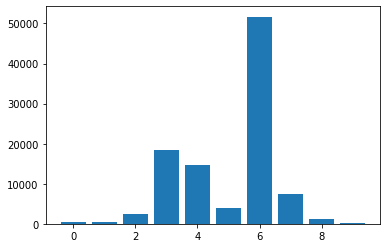

In [160]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y)

# **Data Partition**

Split X into train and test and ensure that the classes are stratified by classes in y

In [156]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((70579, 28), (70579,), (30249, 28), (30249,))

## Oversample

In [157]:
# get_majority_classes finds the 2 major classes and return their labels and sizes
def get_majority_classes(data, label):
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i
      
  print('Max Class %d has %d cases\nSecond Max Class %d len %d' % (max_class, max, max_2_class, max_2) )

  # Separate data into major_data and minor_data dfs
  filt = label == max_class
  major_y_train = label.loc[filt]
  filt2 = label == max_2_class
  major_y_train = major_y_train.append(label.loc[filt2])
  major_train = data.loc[data.index.isin(major_y_train.index)]
  major_train['Labels'] = major_y_train

  # Create minor_train by getting the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]

  return  major_train, minor_train


def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  major_train, minor_train = get_majority_classes(data, label)

  
  print('\n\nBefore upsampling minor classes:', minor_train.shape)
  minor_train = minor_train.groupby('Labels').sample(n = 5000, replace=True) 
  #minor_y_train = minor_train['Labels']

  print('After upsampling:', minor_train.shape, '\n')
  data = major_train.append(minor_train, ignore_index = True)
  data.drop(columns = ['Labels'], inplace = True)
  label = major_train['Labels'].append(minor_train['Labels']).astype('int32') #major_y_train.append(minor_y_train, ignore_index=True )
  #label.astype('int32')
  print_dist(label)

  return data, label

UP_SAMPLE = False #@param {type:"boolean"}
if UP_SAMPLE: 
  x_train, y_train = over_sample(x_train, y_train[0])
  #x_test,  y_test  = over_sample(x_test, y_test[0])

In [158]:
DOWNSAMPLE = False #@param {type:"boolean"}

def down_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by downsampling major classes to the average of minor class

  # Look for the second biggest class
  major_train, minor_train = get_majority_classes(data, label)
  
  print('\n\nBefore downsampling minor classes:', minor_train.shape)
  #minor_train = minor_train.groupby('Labels').sample(n = 5000, replace=True) 
  #minor_y_train = minor_train['Labels']

  print('After downsampling:', minor_train.shape, '\n')
  major_train = major_train.groupby('Labels').sample(n = 5000, replace=False) 

  data = major_train.append(minor_train, ignore_index = True)
  data.drop(columns = ['Labels'], inplace = True)
  label = major_train['Labels'].append(minor_train['Labels'], ignore_index=True ).astype('int32')

  print_dist(label)

  return data, label

if DOWNSAMPLE:
  x_train, y_train = down_sample(x_train, y_train[0])

In [159]:
y_train.value_counts()

6    36176
3    12940
4    10261
7     5265
5     2752
2     1733
8      764
1      324
0      275
9       89
dtype: int64

Use SMOTE to do data augmentation. It creates new instances of minor classes instead of bootstrapping them.

In [161]:
SMOTE = False #@param {type:"boolean"}

if SMOTE:
  !pip install imbalanced-learn
  # import warnings filter
  from warnings import simplefilter
  # ignore all future warnings
  simplefilter(action='ignore', category=FutureWarning)

  from imblearn.over_sampling import SMOTE
  counter = Counter(y_train)
  print('Before SMOTE',counter)

  oversample = SMOTE(k_neighbors = 2, sampling_strategy= 'auto')
  x_train, y_train = oversample.fit_resample(x_train, y_train)
  x_train = pd.DataFrame(x_train)

  # summarize the new class distribution
  counter = Counter(y_train)
  print('After', counter)



In [162]:
# Binarize y_train and y_test so that we can generate classification report and get AUC score per class
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_arr))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_arr))
else:
  y = pd.DataFrame(y)

#n_classes = y.shape[1]

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 10


((70579, 28), (70579, 10), (30249, 28), (30249, 10))

In [163]:
encoded_y_train.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


In [164]:
encoded_y_test.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [165]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(10,6))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=3, fontsize = 8)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('\nTesting Accuracy: %.4f'% accuracy_score(true_labels, pred_labels))
  print('Micro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='micro', multi_class='ovr'))
  print('Macro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='macro', multi_class='ovr'))

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
 
  if n_classes < 20:
    large_vals = cmatrix.max()/2  #comment out because there are too many classes --> no need number
    for i in range(rows):
      for j in range(cols):
        if cmatrix[i, j] >= large_vals:
          color='white'
        else:
          color = 'black'
        plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)
#plt.savefig(model_name + "-CM.jpg", dpi = 100)   
  

## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])  
        roc_auc[i] = auc(fpr[i], tpr[i])

        #if np.isnan( roc_auc[i] ):
        #  roc_auc[i] = 0.5
        #print('ROC AUC Class ',i,':', roc_auc[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc
    
  else:
    #print('Binary classification')
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = auc(measures['fpr'], measures['tpr'])

  return measures


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (roc_type = 'micro'):
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue', 'AL':'mediumpurple', 'AUB':'darkred'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--', 'AL':'+--', 'AUB':'--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT_fpr = DT_test.get('fpr')[roc_type];    DT_tpr = DT_test.get('tpr')[roc_type]; DT_auc = DT_test.get('auc')[roc_type]
    #print(DT, DT_auc)
    RF_fpr   = RF_test.get('fpr')[roc_type];    RF_tpr = RF_test.get('tpr')[roc_type];    RF_auc =  RF_test.get('auc')[roc_type]
    KNN_fpr  = KNN_test.get('fpr')[roc_type];  KNN_tpr = KNN_test.get('tpr')[roc_type];  KNN_auc =  KNN_test.get('auc')[roc_type]
    LGBM_fpr = LGBM_test.get('fpr')[roc_type]; LGBM_tpr= LGBM_test.get('tpr')[roc_type]; LGBM_auc = LGBM_test.get('auc')[roc_type]
    XGB_fpr  = XGB_test.get('fpr')[roc_type];  XGB_tpr = XGB_test.get('tpr')[roc_type];  XGB_auc =  XGB_test.get('auc')[roc_type]
    #BERT_fpr = BERT_test.get('fpr')[roc_type]; BERT_tpr= BERT_test.get('tpr')[roc_type]; BERT_auc = BERT_test.get('auc')[roc_type]
    print('before AL')
    AL_fpr   = AL_test.get('fpr')[roc_type];   AL_tpr  = AL_test.get('tpr')[roc_type];   AL_auc  =  AL_test.get('auc')[roc_type]
    AUB_fpr  = AUB_test.get('fpr')[roc_type];  AUB_tpr = AUB_test.get('tpr')[roc_type];  AUB_auc  = AUB_test.get('auc')[roc_type]

  else:
    DT_fpr = DT_test.get('fpr');      DT_tpr = DT_test.get('tpr');    DT_auc = DT_test.get('auc')
    RF_fpr = RF_test.get('fpr');      RF_tpr = RF_test.get('tpr');    RF_auc = RF_test.get('auc')
    KNN_fpr = KNN_test.get('fpr');    KNN_tpr = KNN_test.get('tpr');  KNN_auc = KNN_test.get('auc')
    LGBM_fpr = LGBM_test.get('fpr');  LGBM_tpr = LGBM_test.get('tpr'); LGBM_auc = LGBM_test.get('auc')
    XGB_fpr = XGB_test.get('fpr');    XGB_tpr = XGB_test.get('tpr');  XGB_auc = XGB_test.get('auc')
    BERT_fpr = BERT_test.get('fpr');  BERT_tpr = BERT_test.get('tpr');BERT_auc = BERT_test.get('auc')

  plt.plot(DT_fpr, DT_tpr,   markers.get('DT'),  color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF_fpr,  RF_tpr,  markers.get('RF'),  color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN_fpr, KNN_tpr, markers.get('KNN'), color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM_fpr,LGBM_tpr,markers.get('LGBM'),color=colors.get('LGBM'),label="LGBM - AUC=" +str( round(LGBM_auc, 4) ))
  plt.plot(XGB_fpr, XGB_tpr, markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))
  #plt.plot(BERT_fpr, BERT_tpr, markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  plt.plot(AL_fpr,  AL_tpr,  markers.get('AL'), color=colors.get('AL'),     label="AL - AUC="+ str( round(AL_auc,4) ))
  plt.plot(AUB_fpr, AUB_tpr, markers.get('AUB'), color=colors.get('AUB'),   label="AUB - AUC="+ str( round(AUB_auc,4) ))

  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right',fontsize= 10) 
  plt.title( 'Testing '+ roc_type+' ROCs on ' + DATA)
  plt.show()

# **Decision Tree**

In [172]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto', class_weight= 'balanced')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

Confusion Matrix: 
 [[   66     0    13    14     2     4    19     0     0     0]
 [    6    76    16    10     5     2     0    18     3     2]
 [   48    15   285   253    41    27     2    16    50     6]
 [  250    89   969  3397   177   212    19   273   108    52]
 [  140    21   153   117  3455    46   239    79   136    12]
 [   25     7    40    48    21  1019     1     2     8     8]
 [  208    23   108   161  1923    23 12915    46    81    17]
 [  110   112    96   103    15     6     1  1707   103     4]
 [   28     8    18    10    19     1     2    23   216     2]
 [    2     0     4     5     3     1     0     1     0    22]]

Classification report:
                precision    recall  f1-score   support

      Analysis       0.21      0.53      0.30       118
      Backdoor       0.22      0.55      0.31       138
           DoS       0.17      0.38      0.23       743
      Exploits       0.82      0.61      0.70      5546
       Fuzzers       0.61      0.79      0.6

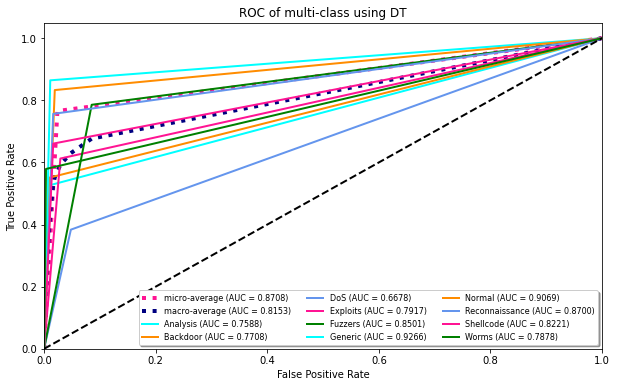

Train Macro AUC: 0.9402 vs Test Macro AUC: 0.8153


In [173]:
# Print performance measures
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')

if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(DT_train['auc']['macro'], DT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))

<Figure size 720x720 with 0 Axes>

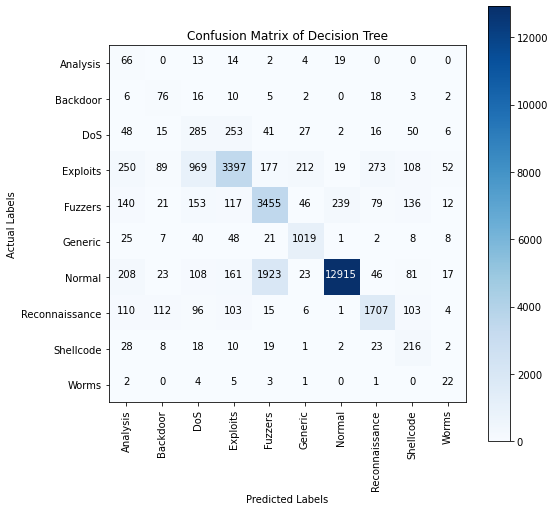

In [174]:
# TESTING Color Confusion Matrix 
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

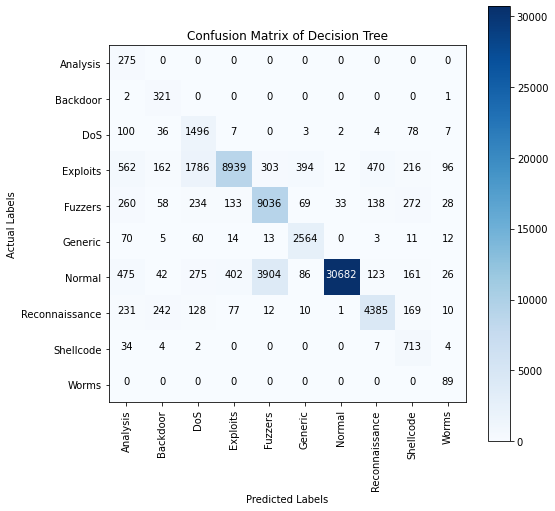

In [175]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_train, y_pred, OG_labels)

# **Random Forest**

Confusion Matrix: 
 [[  112     0     2     4     0     0     0     0     0     0]
 [   37    79     2     3     0     0     0    12     4     1]
 [  274     0   178   227    11     0     0    11    42     0]
 [ 1188     5   131  3902    55     0     1   208    51     5]
 [  497     0     3    13  3779     0    45    10    50     1]
 [  107     1    15    55     3   992     1     0     5     0]
 [  654     0     5    69  2024     0 12729    10    14     0]
 [  203    59     6    34     2     0     0  1953     0     0]
 [   94     0     0     2     9     0     0     3   219     0]
 [   17     0     0     5     0     0     0     0     0    16]]

Classification report:
                precision    recall  f1-score   support

      Analysis       0.29      0.60      0.39       118
      Backdoor       0.55      0.57      0.56       138
           DoS       0.52      0.24      0.33       743
      Exploits       0.90      0.70      0.79      5546
       Fuzzers       0.64      0.86      0.7

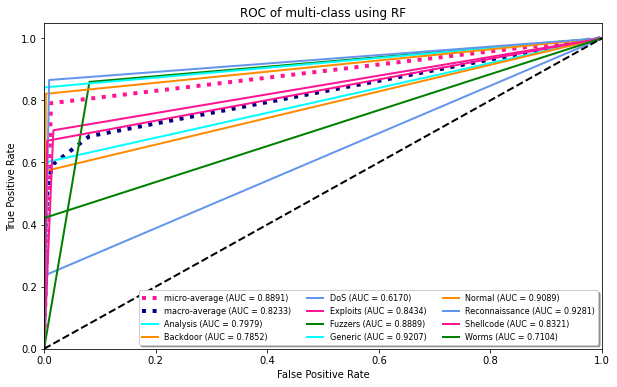

Train Macro AUC: 0.9492 vs Test Macro AUC: 0.8233


In [177]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=20, n_jobs = -1, class_weight='balanced', # added  -1 n_jobs
                                      max_features='auto', bootstrap=True, verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

# Print performance measures
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(RF_train['auc']['macro'], RF_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc'], RF_test['auc']))

<Figure size 720x720 with 0 Axes>

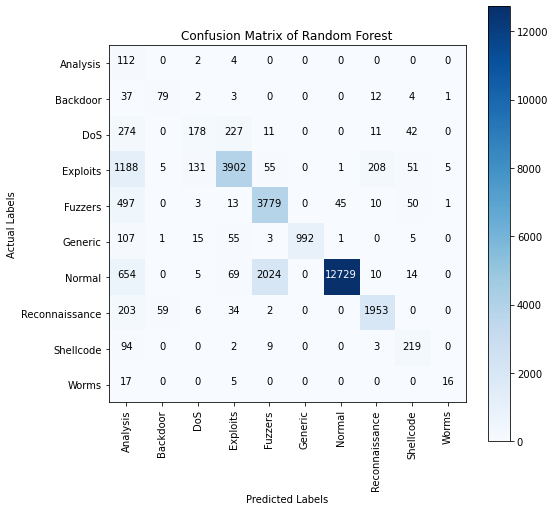

In [178]:
# TESTING Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

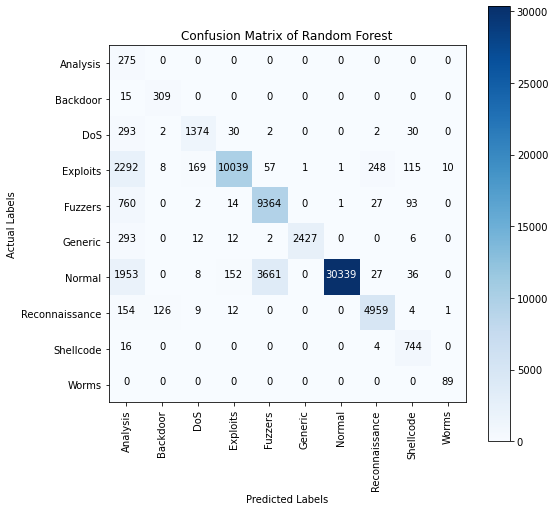

In [179]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_train, y_pred, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

Confusion Matrix: 
 [[   52     0     1    29     9     0    23     4     0     0]
 [   26    16     2    33     6     0    14    41     0     0]
 [  268     0    24   194    91     2   129    26     9     0]
 [ 2031     4    24  1553   689     1  1085   149    10     0]
 [ 1337     1    18   919  1089     8   856   130    39     1]
 [   70     0     1    46    39   987    31     4     1     0]
 [ 1468     0    22  1076   655     3 12155   109    16     1]
 [  599    17    12   425   218     2   291   688     5     0]
 [  103     0     4    51    70     6    49    14    30     0]
 [   13     0     0     7     7     3     8     0     0     0]]

Classification report:
                precision    recall  f1-score   support

      Analysis       0.08      0.01      0.02       118
      Backdoor       0.42      0.12      0.18       138
           DoS       0.22      0.03      0.06       743
      Exploits       0.36      0.28      0.31      5546
       Fuzzers       0.38      0.25      0.3

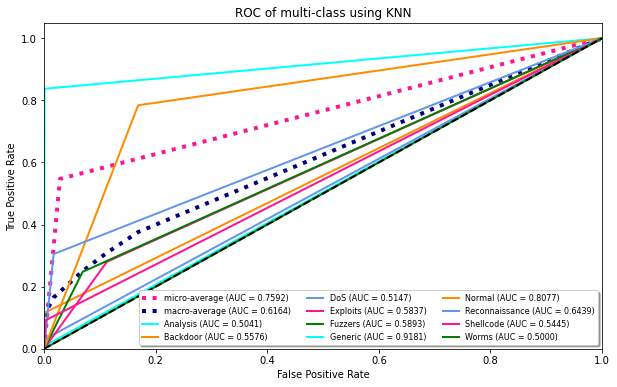

Train Macro AUC: 0.6904 vs Test Macro AUC: 0.6164


In [180]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(KNN_train['auc']['macro'], KNN_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc'], KNN_test['auc']))

<Figure size 720x720 with 0 Axes>

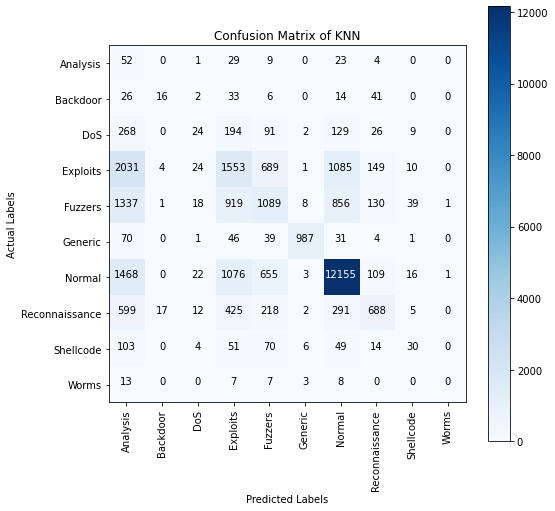

In [181]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

<Figure size 720x720 with 0 Axes>

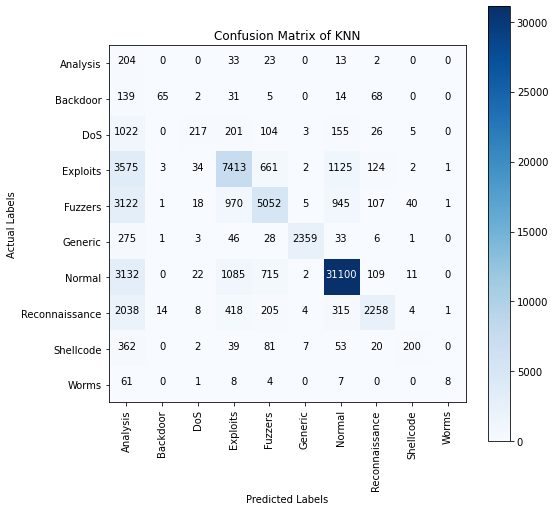

In [182]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_train, y_pred, OG_labels)

# **LightGBM**

<Figure size 720x720 with 0 Axes>

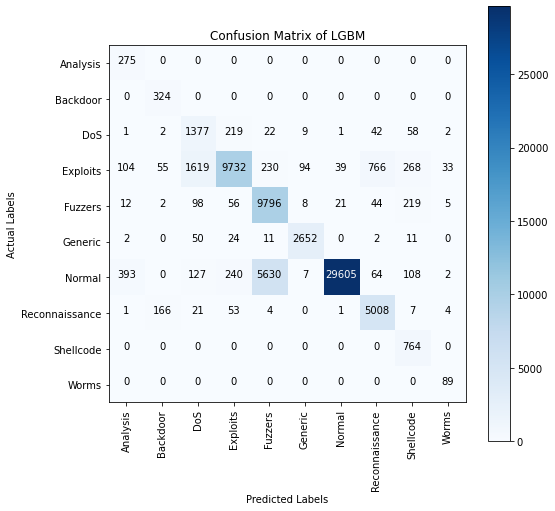

In [183]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass', class_weight='balanced')
 
  #y_pred = label_binarize(y_pred, classes= label_arr)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted: 
y_pred_encoded = label_binarize(y_predicted, classes= label_arr)

# TRAINING Color Confusion Matrix
color_confusion_matrix('LGBM', encoded_y_train, y_pred, OG_labels)

Confusion Matrix: 
 [[   96     0     8     6     2     0     6     0     0     0]
 [    0   100    11     6     0     0     0    12     8     1]
 [   14     4   406   216    28     6     2    11    56     0]
 [   40    31   740  4005   124    64    21   379   122    20]
 [   10     1    50    33  4151     5    28    19   100     1]
 [    1     1    51    50     9  1055     2     2     8     0]
 [  180     2    49    87  2405     3 12702    23    53     1]
 [    1    77    11    62     3     4     0  2097     0     2]
 [    0     1     1     5    13     0     0     0   307     0]
 [    0     1     5     4     0     1     0     0     0    27]]

Classification report:
                precision    recall  f1-score   support

      Analysis       0.28      0.81      0.42       118
      Backdoor       0.46      0.72      0.56       138
           DoS       0.30      0.55      0.39       743
      Exploits       0.90      0.72      0.80      5546
       Fuzzers       0.62      0.94      0.7

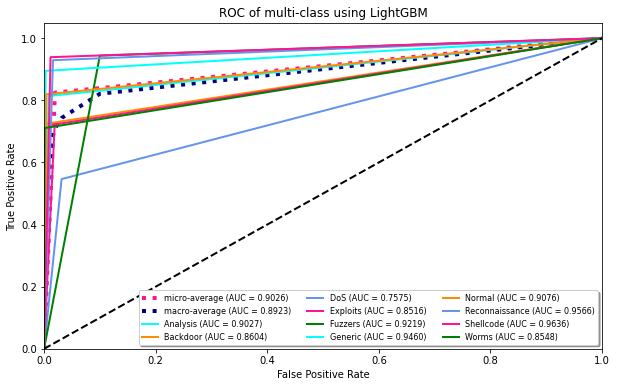

Train Macro AUC: 0.9530 vs Test Macro AUC: 0.8923


In [184]:
# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(LGBM_train['auc']['macro'],LGBM_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc'], LGBM_test['auc']))

<Figure size 720x720 with 0 Axes>

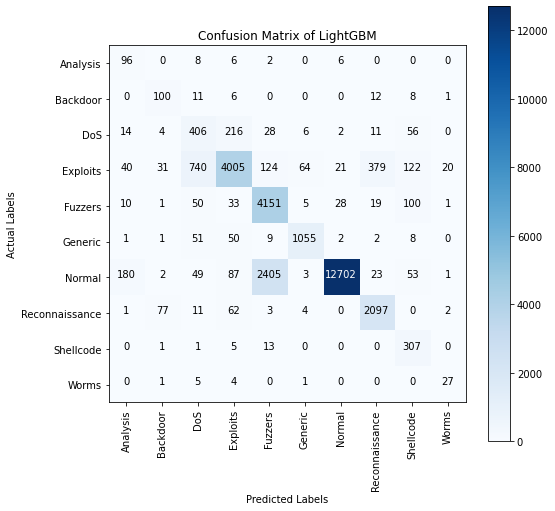

In [185]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**

<Figure size 720x720 with 0 Axes>

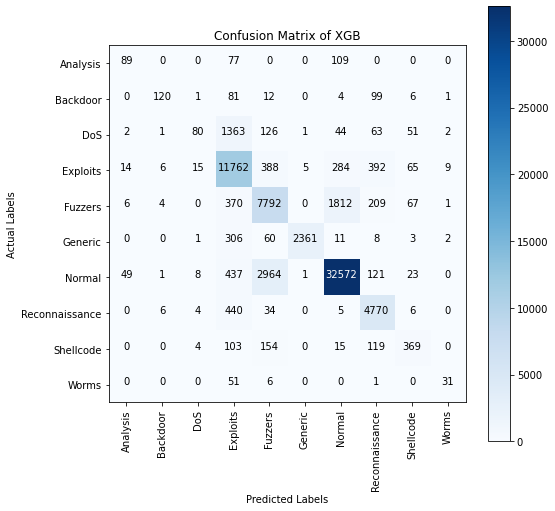

In [186]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="mlogloss", objective = "multi:softprob")  ## change from logloss to mlogloss and add objective

xgb.fit(x_train, y_train.values.ravel())
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)

# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted, classes= label_arr)

#  TRAIN Color Confusion Matrix
color_confusion_matrix('XGB', encoded_y_train, y_pred, OG_labels)

Confusion Matrix: 
 [[   38     0     0    29     1     0    50     0     0     0]
 [    0    43     0    41     7     0     5    41     1     0]
 [    0     0    30   581    52     0    24    21    34     1]
 [    3     4    10  5039   185     4   111   163    25     2]
 [    3     1     2   166  3333     0   790    82    21     0]
 [    0     1     1   146    26   990     8     2     5     0]
 [   38     1     0   196  1241     1 13965    54     8     1]
 [    1     5     2   235    12     2     1  1998     1     0]
 [    0     0     0    62    62     0     3    49   151     0]
 [    0     0     0    22     6     0     0     0     1     9]]

Classification report:
                precision    recall  f1-score   support

      Analysis       0.46      0.32      0.38       118
      Backdoor       0.78      0.31      0.45       138
           DoS       0.67      0.04      0.08       743
      Exploits       0.77      0.91      0.84      5546
       Fuzzers       0.68      0.76      0.7

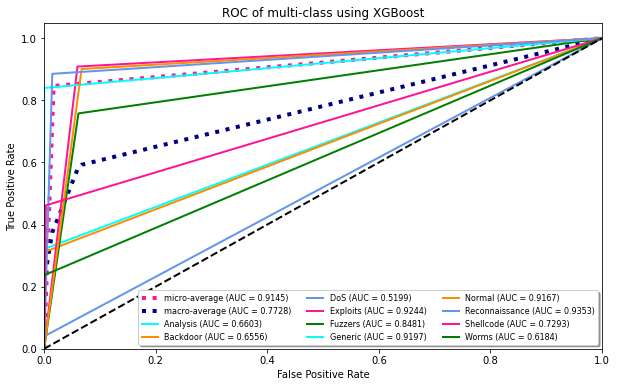

Train Macro AUC: 0.7849 vs Test Macro AUC: 0.7728


In [187]:
# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(XGB_train['auc']['macro'], XGB_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))

<Figure size 720x720 with 0 Axes>

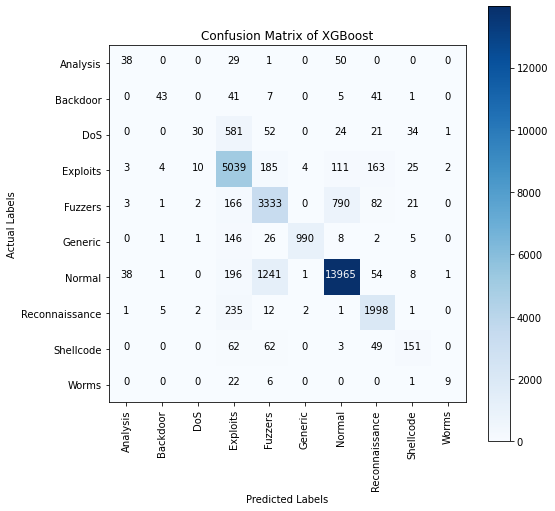

In [188]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

# **Multi-class BERT**

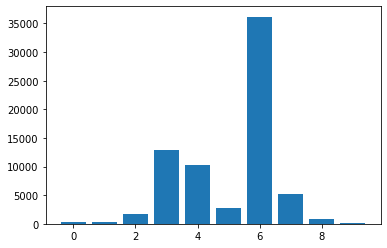

In [189]:
# plot the distribution
print_dist(y_train)

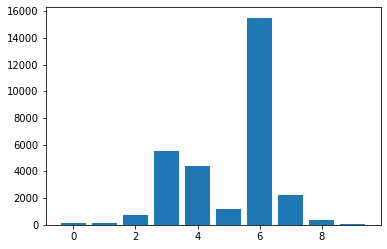

In [190]:
# plot the distribution
print_dist(y_test)

## **Combining all features into a sentence**

In [191]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

In [192]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [193]:
#train_texts

In [194]:
encoded_y_test.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [195]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 3.3 MB 61.4 MB/s 
     |████████████████████████████████| 636 kB 74.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [196]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [197]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_arr), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
label (Dense)                (None, 10)                7690      
Total params: 109,489,930
Trainable params: 109,489,930
Non-trainable params: 0
_________________________________________________________________


In [1]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
#y_label = to_categorical(train_labels)

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_y_train},
    validation_split=0.2,
    batch_size=128,
    epochs=2)

NameError: ignored

In [2]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_arr)
# Recording TPR and FPR for TRAINING-ROC curves
BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 

NameError: ignored

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
#test_y_label   = to_categorical(test_labels)

test_x = tokenizer(
    text= list(test_texts), 
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_y_test}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_arr)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
BERT_test = record_measures( encoded_y_test, y_pred_encoded) 

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(BERT_train['auc']['macro'], BERT_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# TESTING Color Confusion Matrix
color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)

In [ ]:
# TRAINING Color Confusion Matrix
color_confusion_matrix('BERT', encoded_y_train, y_train_pred_encoded, OG_labels)

In [ ]:
AL_test['fpr']['micro']

In [ ]:
AL_fpr   = AL_test.get('fpr')['macro'];   AL_tpr  = AL_test.get('tpr')['macro'];   AL_auc  =  AL_test.get('auc')['macro']

In [ ]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8889 --NotebookApp.port_retries=0

# **Note**

- Before cleaning data, BERT only get AUC = 0.86, while the other algs achieved AUC above 0.90.

- After cleaning data, BERT performance is improved to AUC = 0.92, and other algs has AUC above 0.93. However, since this dataset has 36 classes ( 1 normal and 35 intrusions), most algs do not classify normal cases well, they often mistake normal class for intrusion classes. 

--> We increased the number of cases per class from 135 to over 275, which improves f-1 score on normal class overall (F-1 Scores are above 0.77) --> still have room for improvement on normal class.
 
 --> We increase the number of cases from only normal class to see if its F1-Score can get better (Normal class vs. Intrusion classes ratio 2:1). Result: Only LightGBM and XGBoost gets better at classifying Normal class (F1-Score above 0.92), yet no improvement on DT, RF, KNN and BERT.

 --> Normal class vs. intrusion class ratio 2:1, and not removing intrusion classes from normal. Result: no difference

 --> Normal class vs. intrusion class ratio 1:1, and remove all intrusion classes from normal class. Result: Only LightGBM and XGBoost classify normal class well (Normal F1-Score above 0.88)


*   BERT note: when increasing number of training and testing sets to around 10K, BERT needs at least 10 epochs to efficiently train and validate and to achieve above 0.85 accuracy. --> Takes longer to run 
*   List item


**Next Step:**
- Narrowing down the number of classes by including only 5 or 10 classes in the training and testing sets. The purpose of this experiment is to see if BERT performance is improved when there are fewer classes. 

**Current Code Note**

This current version do not oversample minor classes. The training and testing sets are split based on stratified y. 
--> LightGBM do not work well on extremely imbalance data, so it yields the worst result. Yet BERT is doing pretty well so far

Most algorithms achieve high accuracy but low AUC due to the major class is Normal. 

When downsample major classes in train set, most algs perform similar to when upsampling minor classes except LGBM and XGB, which perform slightly better than when upsampling minor classes. Overall, downsampling reduces training time significantly without affect the models' micro and macro performances. When upsampling, LGBM performs poorly on neptune (0.59) and normal classes (0.53) (aka the 2 major classes). However, its performance on these 2 classes improve significantly (neptune - 0.8 and normal - 0.66). 

When downsample major classes and use SMOTE on minor classes (data augmentation), all algs except LGBM perform similar to when downsample. LGBM improves significantly from 0.14 accuracy to 0.99, 0.02 macro F1 to 0.65.


1.   List item
2.   List item



# **AdaUBoostClassifier - Imbalanced-Ensemble Method**

In [ ]:
#!pip install imbalanced_ensemble --quiet

In [ ]:
#
import imbalanced_ensemble as imbens
from imbalanced_ensemble.ensemble import AdaUBoostClassifier

AUB_clf = AdaUBoostClassifier(base_estimator= decTree)
AUB_clf.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = AUB_clf.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)

AUB_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = AUB_clf.predict(x_test)
encoded_y_pred = label_binarize(y_predicted, classes= label_arr)

# Recording TPR and FPR for TESTING-ROC curves
AUB_test = record_measures(encoded_y_test, encoded_y_pred)

In [ ]:
# Print performance measures
print_performance('AdaUBoost', encoded_y_test, encoded_y_pred, OG_labels)


# Print ROC Curve
plot_ROC(AUB_test, labels_dict, 'AdaUBoost')
if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(AUB_train['auc']['macro'], AUB_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(AUB_train['auc'],AUB_test['auc']))

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('AdaUBoost', encoded_y_test, encoded_y_pred, OG_labels)

**Computing Class Weight**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', label_arr, y_train)

weights

In [ ]:
class_weights = dict(zip(label_arr, weights ))
class_weights

# **Active Learning**

In [ ]:
# Split train set into labelled data and unlabelled data (pool)
x_labelled, x_pool, y_labelled, y_pool = train_test_split(x_train, y_train, test_size = 0.30, stratify = y_train)

# Reset index in these dfs
x_lablled, y_labelled = x_labelled.reset_index(drop=True), y_labelled.reset_index(drop=True)
x_pool,  y_pool      = x_pool.reset_index(drop=True),     y_pool.reset_index(drop=True)


x_labelled.shape, y_labelled.shape, x_pool.shape, y_pool.shape

In [ ]:
#! pip install modAL --quiet

In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.ensemble import RandomForestClassifier

# Creating model
learner = ActiveLearner(
    estimator=xgb,
    query_strategy=uncertainty_sampling,
    X_training = x_labelled, y_training = y_labelled.values.ravel() # y_labelled.values.ravel() means convert it to series and then reshape/flatten it
)

# Before trainning on unlabelled data
print('Score before query', learner.score(x_pool, y_pool))

# Find 10 most confusing data instances and train on them
for i in range(10):
  # Get the most confusing unlabelled data instance
  query_idx, query_sample = learner.query(x_pool)
  print('Query ', i, ': ', query_idx)
  # Train the model with the data found above along with its label
  learner.teach(query_sample, y_pool.iloc[query_idx[0]])

# After training with unlabelled data
print('Score after query', learner.score(x_pool, y_pool))
#--------------------------------------------------------------------

# Predicting train set
y_pred = learner.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_arr)

# Recording TPR and FPR for TRAINING-ROC curves
AL_train = record_measures(encoded_y_train, y_pred)

# Predicting test set
y_pred = learner.predict(x_test)
y_predicted = label_binarize(y_pred, classes= label_arr)

# Recording TPR and FPR for TESTING-ROC curves
AL_test = record_measures(encoded_y_test, y_predicted)

# Print performance measures
print_performance('Active Learner', encoded_y_test, y_predicted, OG_labels)

# Print ROC Curve
plot_ROC(AL_test, labels_dict, 'AL')

if n_classes > 2:
  print('Train Macro AUC: %.4f vs Test Macro AUC: %.4f' %(AL_train['auc']['macro'], AL_test['auc']['macro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(AL_train['auc'], AL_test['auc']))

In [ ]:
learner.score(x_test, y_test)

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the Micro ROC curves on testing results:
graph_multi_ROC('micro')

# Ploting the Macro ROC curves on testing results:
graph_multi_ROC('macro')